# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It extends the notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Creating GWL plots

28/02/2023, [Santander Meteorology Group](http://www.meteo.unican.es)

*J. Fernández* - Instituto de Física de Cantabria (IFCA), CSIC-Universidad de Cantabria, Santander, Spain.

Global Warming Level (GWL) plots summarize the regional climate sensitivity of changes in different variables as a function of global mean surface air temperature changes. Decadal mean changes for the different members of a multimodel ensemble provide the sample to study the relationship between regional climate sensitivity and GWL. These plots are generated by the IPCC WGI AR6 Interactive Atlas (http://interactive-atlas.ipcc.ch) and are reproduced in this notebook using the data available in the Atlas repository. As in the interactive Atlas, the notebook allows to set different variables (tas or pr), masks (land, sea, landsea), scenarios, reference regions, etc.

### Import packages

In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from sklearn import linear_model
from urllib.request import urlopen

### Set parameters

In [2]:
var = 'tas'
mask = 'landsea'
project = 'CMIP6' # CMIP5, CMIP6
project_gsat = 'CMIP6' # CMIP5 or CMIP6
scenario = 'ssp585' # e.g. ssp585 or rcp45
region = 'MED'
season = 'Annual'
period_global = slice('1850','1900')
period_region = slice('1850','1900')
gwl_period = 10 # years running window
gwl_step = 0.25
gwls = np.arange(1,8.1,gwl_step)

The following, in principle, require no modification. It is just information for labels and season selection.

In [3]:
longname = dict(pr = 'Precipitation', tas = 'Near surface temperature')
units = dict(pr='%', tas='K')
months = dict(DJF=[1,2,12], MAM=[3,4,5], JJA=[6,7,8], SON=[9,10,11], Annual=range(1,13))

### Compute decadal anomalies

We define first some commodity functions

In [4]:
def list_files(project, scenario, var, mask):
  '''List remote CSV files from the IPCC WGI Atlas repository'''
  repo = 'IPCC-WG1/Atlas'
  tag = 'v2.0-final'
  basedir = f'datasets-aggregated-regionally/data/{project}/{project}_{var}_{mask}'
  contents_url = f'https://api.github.com/repos/{repo}/contents/{basedir}?ref={tag}'
  raw_baseurl = f'https://raw.githubusercontent.com/{repo}/{tag}/{basedir}/'
  data_json = json.loads(urlopen(contents_url).read())
  file_list = [raw_baseurl + item['name'] for item in data_json if scenario in item['name']]
  return(file_list)

def read_existing_csv(csvurl):
  try:
    return(pd.read_csv(csvurl, comment = '#'))
  except:
    print(f'Problem reading {csvurl}')

def read_files(csvlist):
  '''Concatenates a list of CSV files as a dataframe'''
  csvdata = [read_existing_csv(csv) for csv in csvlist]
  csvdata = pd.concat(csvdata)
  csvdata['date'] = pd.to_datetime(csvdata['date'], format='%Y-%m')
  return(csvdata.set_index('date'))

def get_average(df, period, region = 'world', season = 'Annual'):
  '''Computes the seasonal average for a given region and period'''
  rval = df.loc[period,region]
  return(rval[rval.index.month.isin(months[season])].mean())

def get_run(filepath):
  '''Extracts member identifier from filename'''
  return( filepath.split('_')[-1].split('.')[0] )

def get_model(filepath):
  '''Extracts model name from filename'''
  return( filepath.split('_')[-3].split('.')[0] )

We can now compute decadal anomalies for the selected variable and for global mean surface air temperature as reference. The abscissas in this plot always represent the GWL so the variable is always `tas` and no mask is applied (`landsea`), regardless of the selection above for the variable in the Y axis.

In [5]:
%%time

def regional_anomalies(project, scenario, var = 'tas', mask = 'landsea', region = 'world', season = 'Annual', relative = False):
  data = pd.DataFrame(columns = ['model', 'run', 'gwl', region])
  relative = var=='pr'
  files_scen = list_files(project, scenario, var, mask)
  for scenfile in files_scen:
    # global gsat
    scenfile_gsat = scenfile.replace(f'_{var}_', '_tas_')
    scenfile_gsat = scenfile_gsat.replace(f'_{mask}/', '_landsea/')
    histfile_gsat = scenfile_gsat.replace(scenario, 'historical')
    member_data_gsat = read_files([histfile_gsat, scenfile_gsat])
    reference_global = get_average(member_data_gsat, period_global, 'world', 'Annual')
    yearmean_gsat = member_data_gsat.resample('Y').mean()
    # regional var
    histfile = scenfile.replace(scenario, 'historical')
    member_data = read_files([histfile, scenfile])
    reference_region = get_average(member_data, period_region, region, season)
    yearmean = member_data.resample('Y').mean()
    for gwl in gwls:
      gwl_year = (yearmean_gsat['world']-reference_global).rolling(gwl_period, center = True).mean().ge(gwl).idxmax()
      try:
        rwl = (yearmean[region]-reference_region).rolling(gwl_period, center = True).mean().loc[gwl_year]
      except KeyError:
        print(f'Cannot find {gwl_year} in {scenfile}')
        continue
      dfrow = dict(
        model = get_model(scenfile),
        run = get_run(scenfile),
        gwl = gwl
      )
      dfrow[region] = rwl
      if relative:
        dfrow[region] = 100. * dfrow[region] / reference_region
      data = data.append(dfrow, ignore_index=True)
  return(data.set_index(['model', 'run']).dropna())

data = regional_anomalies(project, scenario, var, mask, region, season, relative = var=='pr')

CPU times: user 7.3 s, sys: 506 ms, total: 7.81 s
Wall time: 34.6 s


We have now all the information we need to construct the GWL Plot in a single dataframe object:

In [6]:
data

gwl       MED
model       run                     
ACCESS-CM2  r1i1p1f1  1.00  1.043156
            r1i1p1f1  1.25  1.392656
            r1i1p1f1  1.50  1.729264
            r1i1p1f1  1.75  1.970822
            r1i1p1f1  2.00  2.230397
...                    ...       ...
UKESM1-0-LL r1i1p1f2  5.75  6.389613
            r1i1p1f2  6.00  6.673038
            r1i1p1f2  6.25  7.069630
            r1i1p1f2  6.50  7.388696
            r1i1p1f2  6.75  7.662855

[571 rows x 2 columns]

### GWL Plot

The GWL Plot is now just a scatterplot of the region vs. the world columns in this dataframe. We might colour the individual points according to their gwl, and add gwl averages on top, as in the Interactive Atlas.

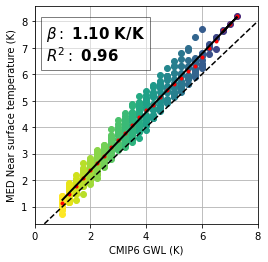

In [7]:
colors = cm.get_cmap('viridis_r', len(gwls))
fig, ax = plt.subplots(figsize=(4,4))
h = []
for k,gwl in enumerate(gwls):
  decdata = data[data['gwl'] == gwl]
  h.append(ax.scatter(x=decdata['gwl'], y=decdata[region], color=colors(k)))
# Set legend outside the plot
##.legend(h, gwls, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# Add gwl means
gwl_means = data.groupby('gwl').mean()
ax.plot(gwl_means.index, gwl_means[region], 'or', markersize=3)
# Add linear fit
lm = linear_model.LinearRegression()
X = data['gwl'].values.reshape(-1, 1)
y = data[region]
model = lm.fit(X, y)
ax.set_xlim(left=0)
ax.set_xlim(0,8)
#ax.set_ylim(-42,12)
ax.text(0.05, 0.92, '$\\beta:$ %.2f %s/K\n$R^2:$ %4.2f' % (model.coef_, units[var], lm.score(X, y)), color='k',
        verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, 
        fontsize=15, fontweight = 'bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5})
ax.plot(X, model.predict(X), color = 'k', linewidth = 2)
# Grid and labels
ax.set_axisbelow(True)
ax.grid()
if var == 'tas':
  ax.axline((1, 1), slope=1, ls="--", c="k")
plt.xlabel(f'{project_gsat} GWL (K)')
plt.ylabel(f'{region} {longname[var]} ({units[var]})')
#plt.savefig(f'independent-GWL-plot-{project}_{scenario}_{region}_{var}_{mask}.png', dpi=150, bbox_inches = 'tight', facecolor = 'w')
plt.savefig(f'independent-GWL-plot-{project}_{scenario}_{region}_{var}_{mask}_w{gwl_period}_s{int(gwl_step*100):02d}.pdf', format='pdf', bbox_inches = 'tight')